# Transfer Learning Experiments

Created by: Jacob A Rose  
Created On: Wednesday Oct 6th, 2021  

Based on Notebook located at: https://jarvislabs.ai/blogs/transfer-learning

## Imports & Definitions

In [1]:
from rich import print as pp

# import lux
import pandas as pd
# lux.config.default_display = "pandas"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models, transforms as t
from fastprogress.fastprogress import master_bar, progress_bar
import matplotlib.pyplot as plt
import time
import os
import copy
from pathlib import Path

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import logging

logger = logging.Logger(__name__)
logger.setLevel('INFO')

In [3]:
from tqdm.auto import tqdm, trange


### Creating Model

In [4]:
from prettytable import PrettyTable

def count_parameters(model, verbose: bool=True):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    trainable_params = 0
    for name, parameter in model.named_parameters():
        param = parameter.numel()
        
        total_params += param
        if not parameter.requires_grad:
            continue
        table.add_row([name, param])
        trainable_params+=param
    if verbose:
        print(table)
    print(f"Total Trainable Params: {trainable_params:,}")
    print(f"Total non-Trainable Params: {total_params-trainable_params:,}")
    return table



from more_itertools import unzip
from toolz.itertoolz import concat

def collect_results(results):
    """
    Converts a list of flat records/rows to a list of tall, row-wise concatenated columns
    
    Useful for collecting a set of batches or individual samples of 0- and 1-dimensional tensors returned by each model step, collected in a list in model.on_epoch_end.
    
    in:
        [(item_00, item_01,... item_0C),
         (item_10, item_11,... item_1C),
         ...
         (item_N0, item_N1,... item_NC)]
     out:
         [[item_00, item_10,... item_N0],
         [item_01, item_11,... item_N1],
         ...
         [item_0C, item_1C,... item_NC]]
    
    """

    rows = [list(concat(r)) for r in unzip(results)]
    cols = []*len(rows)
    print(cols)
    for i, row in enumerate(rows):
        if isinstance(row[0], torch.Tensor):
            if len(row[0].shape) <= 1:
                cols.append(torch.stack(row, dim=0).cpu().numpy())
            else:
                cols.append(torch.cat(row).cpu().numpy())
        elif isinstance(row[0], list):
            cols.extend(list(concat(row)))
        elif isinstance(row[0], (str, int)):
            cols.append(list(row))

    np.all([len(c)==len(cols[0]) for c in cols])
    
    return cols





# table = count_parameters(model)

# print(table)

In [5]:
# source: https://github.com/hirune924/lightning-hydra/blob/master/layer/layer.py
import torch
import torch.nn as nn
import pytorch_lightning as pl
# from typing import Optional
import timm
import glob
import hydra
from collections import OrderedDict
from typing import *


class Flatten(nn.Module):
    def forward(self,x):
        return torch.flatten(x, start_dim=1)
    

class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."

    def __init__(self, sz: Optional[int] = None):
        super(AdaptiveConcatPool2d, self).__init__()
        "Output will be 2*sz or 2 if sz is None"
        self.output_size = sz or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)

    def forward(self, x):
        return torch.cat([self.mp(x), self.ap(x)], 1)
    

def build_global_pool(pool_type: str="avg",
                      pool_size: int=1, 
                      feature_size: Optional[int]=0):

#     head = OrderedDict()
    if pool_type == 'avg':
        global_pool = nn.AdaptiveAvgPool2d(pool_size)
        return global_pool, feature_size
        
    elif pool_type == 'avgdrop':
        global_pool = nn.Sequential(nn.AdaptiveAvgPool2d(pool_size),
                                    nn.Dropout2d(p=0.3, inplace=False))
        return global_pool, feature_size
    elif pool_type == 'avgmax':
        feature_size = feature_size * 2
        global_pool = AdaptiveConcatPool2d(pool_size)
        return global_pool, feature_size

    elif pool_type == 'max':
        global_pool = nn.AdaptiveMaxPool2d(pool_size)
        return global_pool, feature_size
    
    else:
        raise NotImplementedError(f"pool_type={pool_type} invalid.")


def load_model_checkpoint(model, ckpt_path: str):
    ckpt_path = glob.glob(hydra.utils.to_absolute_path(ckpt_path))
    model = model.load_state_dict(torch.load(ckpt_path[0]))
    return model

from collections import OrderedDict

def build_timm_backbone(backbone_name='gluon_seresnext50_32x4d',
                         pretrained: Union[bool, str]=True,
                         num_classes: int=1000,
                         feature_layer: int=-2):
    if pretrained == "imagenet":
        num_classes = 1000

    model = timm.create_model(model_name=backbone_name, num_classes=num_classes, pretrained=pretrained)
    if isinstance(pretrained, str) and pretrained != "imagenet":
        model = load_model_checkpoint(model, ckpt_path=pretrained)
        
#     body = nn.Sequential(*list(model.children())[:feature_layer])

    body = nn.Sequential(OrderedDict(list(model.named_children())[:feature_layer]))
    
    return body


def build_model_backbone(backbone_name='gluon_seresnext50_32x4d',
                         pretrained: Union[bool, str]=True,
                         num_classes: int=1000,
                         feature_layer: int=-2,
                         model_repo: str= "timm"):

    if model_repo == "timm":
        return build_timm_backbone(backbone_name=backbone_name,
                                   pretrained=pretrained,
                                   num_classes=num_classes,
                                   feature_layer=feature_layer)
    # TBD Add other pretrained model backends
    raise NotImplementedError(f"Invalid model_repo={model_repo}")
    

def build_model_head(num_classes: int=1000,
                     pool_size: int=1,
                     pool_type: str='avg',
                     head_type: str='linear',
                     feature_size: int=512,
                     hidden_size: Optional[int]=512):
    """
    
    Returns a nn.Sequential model containing 3 children:
        global_pool -> flatten -> classifier
        
    Available pool_types:
        - "avg"
            global_avg_pool
        - "avgdrop"
            global_avg_pool -> dropout
        - "avgmax"
            [global_avg_pool | global_max_pool]
        "max"
            global_max_pool
            
            
    pool_types to be explored:
        - "maxdrop"
            global_max_pool -> dropout
        - "avgmaxdrop"
            [global_avg_pool | global_max_pool] -> dropout

        
    Available head_types:
        - linear
        
        - custom
    
    """

    head = OrderedDict()
    global_pool, feature_size = build_global_pool(pool_type=pool_type,
                                                  pool_size=pool_size,
                                                  feature_size=feature_size)
    head["global_pool"] = global_pool
    head["flatten"] = Flatten()
    
    classifier_input_feature_size = feature_size*(pool_size**2)
    if head_type=='linear':
        hidden_size = 0
        head["classifier"] = nn.Linear(classifier_input_feature_size, num_classes)
    elif head_type=='custom':
        head["classifier"] = nn.Sequential(nn.Linear(classifier_input_feature_size, hidden_size),
                                nn.RReLU(lower=0.125, upper=0.3333333333333333, inplace=False),
                                nn.BatchNorm1d(hidden_size),
                                nn.Linear(hidden_size, num_classes))
    head = nn.Sequential(head)
    return head



def build_model(backbone_name='gluon_seresnext50_32x4d',
                pretrained: Union[bool, str]=True,
                num_classes: int=1000,
                pool_size: int=1,
                pool_type: str='avg',
                head_type: str='linear',
                hidden_size: Optional[int]=512):
    
    backbone = build_model_backbone(backbone_name=backbone_name,
                                    pretrained=pretrained,
                                    num_classes=num_classes,
                                    feature_layer=-2)
    
    feature_size = list(backbone.parameters())[-1].shape[0]
    

    head = build_model_head(num_classes=num_classes,
                            pool_size=pool_size,
                            pool_type=pool_type,
                            head_type=head_type,
                            feature_size=feature_size,
                            hidden_size=hidden_size)
    
    model = nn.Sequential(OrderedDict({
        "backbone":backbone,
        "head":head
    }))
    return model

In [6]:
from lightning_hydra_classifiers.utils.metric_utils import get_per_class_metrics, get_scalar_metrics
                
class LayerSelectPlugin:
    """
    LayerSelectPlugin

    To be subclassed by main Pytorch Lightning Module
    
    Available methods:
    * classmethods:
        - count_parameters
    * instance methods:
        - get_batchnorm_modules
        - get_conv_modules
        - get_linear_modules
        - get_named_parameters
        - get_named_modules
        - get_trainable_parameters
        - get_nontrainable_parameters
        - count_trainable_batchnorm_layers

    
    
    """
    def get_batchnorm_modules(self):
        return self.get_named_modules("bn")
    
    def get_conv_modules(self):
        return self.get_named_modules("conv")
    
    def get_linear_modules(self):
        return ((n,m) for n,m in self.named_modules() if isinstance(m, nn.modules.Linear))
    
    
    def get_named_parameters(self,
                             filter_pattern: Optional[str]=None,
                             trainable: bool=False,
                             nontrainable: bool=False):
        
        named_params = self.named_parameters()
        if isinstance(filter_pattern, str):
            named_params = ((n,p) for n,p in named_params if filter_pattern in n)
        if trainable and nontrainable:
            logger.warning('Returning all parameters regardless of the values of requires_grad.')
            return named_params
        if trainable:
            return ((n, p) for n, p in named_params if p.requires_grad)
        if nontrainable:
            return ((n, p) for n, p in named_params if not p.requires_grad)
        return named_params

    def get_named_modules(self,
                          filter_pattern: Optional[str]=None):
        if isinstance(filter_pattern, str):
            return ((n,l) for n,l in self.named_modules() if filter_pattern in n)
        return self.named_modules()
            
    def get_trainable_parameters(self):
        return (p for _, p in self.get_named_parameters(trainable=True))
#         return (p for p in self.parameters() if p.requires_grad)

    def get_nontrainable_parameters(self):
        return (p for _, p in self.get_named_parameters(nontrainable=True))
#         return (p for p in self.parameters() if not p.requires_grad)

    def count_trainable_batchnorm_layers(self) -> None:
        is_training = np.array([m.training for _, m in self.get_batchnorm_modules()])
        print(f"trainable batchnorm modules:{np.sum(is_training)}")
        print(f"nontrainable batchnorm modules:{np.sum(~is_training)}")

        is_training = np.array([p.requires_grad for _, p in self.get_named_parameters("bn")])
        print(f"batchnorm params with requires_grad=True: :{np.sum(is_training)}")
        print(f"batchnorm params with requires_grad=False:{np.sum(~is_training)}")
        
    @classmethod
    def count_parameters(cls, model, verbose: bool=True) -> PrettyTable:
        return count_parameters(model, verbose=verbose)


    
class FinetuningLightningPlugin:
    """
    FinetuningLightningPlugin
    
    To be subclassed by main Pytorch Lightning Module
    
    Available methods:
    * classmethods:
        - freeze_up_to
        - freeze
        - unfreeze
        - freeze_bn
        - set_bn_eval
    * instance methods:
        - freeze_backbone
        - unfreeze_backbone_top_layers
    """
    
    
    
    @classmethod
    def freeze_up_to(cls, 
                     module, 
                     stop_layer: Union[int, str]=None,
                     freeze_bn: bool=True):

        cls.unfreeze(module, freeze_bn=freeze_bn)

        if isinstance(stop_layer, str):
            modules = list(module.named_modules())
        elif isinstance(stop_layer, int) or (stop_layer is None):
            modules = list(enumerate(module.modules()))

        for module_id, m in modules:
            if stop_layer == module_id:
                logger.warning(f"Stopping at layer: {n}")
                break
            cls.freeze(m, freeze_bn=freeze_bn)
#             for param_id, param in m.named_parameters():
#                 param.requires_grad = False
#             m.eval()
#             cls.freeze_bn(m, freeze_bn)
            logger.warning(f"Layer {module_id}: type={type(m)}|training={m.training}")
            logger.warning(f"requires_grad={np.all([p.requires_grad for p in m.parameters()])}")

    @classmethod
    def freeze(cls,
               module,
               freeze_bn: bool=True,
               filter_pattern: Optional[str]=None):
        modules = list(module.named_modules())
        for n, m in modules:
#             if filter_pattern not in n:
            if isinstance(filter_pattern, str) and (filter_pattern not in n):
                continue
#             m.eval()
            for p_name, p in m.named_parameters():
#                 if filter_pattern not in n:
                if isinstance(filter_pattern, str) and (filter_pattern not in n):
                    continue
                if freeze_bn or not isinstance(m, nn.BatchNorm2d):
                    p.requires_grad=False
            cls.freeze_bn(m, freeze_bn)        

            
    @classmethod
    def unfreeze(cls,
                 module,
                 filter_pattern: Optional[str]=None):
        modules = list(module.named_modules())
        for n, m in modules:
            if isinstance(filter_pattern, str) and (filter_pattern not in n):
                continue
            for p_name, p in m.named_parameters():
                p.requires_grad=True
            m.train()

                
    @classmethod
    def freeze_bn(cls, module: nn.Module, freeze_bn: bool):
        for m in module.modules():
            if isinstance(m, nn.BatchNorm2d): 
                if freeze_bn:
                    for p in m.parameters():
                        p.requires_grad = False
#                     m.eval() 
#                 else:
#                     m.train()

    @classmethod
    def set_bn_eval(cls, module: nn.Module)->None:
        "Set bn layers in eval mode for all recursive children of `m`."
        for l in module.children():
            if isinstance(l, nn.BatchNorm2d) and not next(l.parameters()).requires_grad:
                l.eval()
            cls.set_bn_eval(l)


    def freeze_backbone(self, freeze_bn: bool=True):
        
        self.freeze(self.model.backbone,
                    freeze_bn=freeze_bn)
        self.unfreeze(self.model.head)

        
    def unfreeze_backbone_top_layers(self,
                                     unfreeze_down_to: Union[str,int]=-1):
        if isinstance(unfreeze_down_to, str):
            layers = list(reversed(list(self.model.backbone.named_children())))
        if isinstance(unfreeze_down_to, int):
            if unfreeze_down_to == 0:
                print(f"Pass non-zero integer or str label name to unfreeze layers. Returning without change.")
                return
            layers = list(reversed(list(enumerate(self.model.backbone.children()))))
            if unfreeze_down_to < 0:
                unfreeze_down_to = len(layers) + unfreeze_down_to
        
        for layer_id, l in layers:
            if layer_id == unfreeze_down_to:
                break
            self.unfreeze(l)



class LightningMetricsPlugin:
    """
    LightningMetricsPlugin
    
    To be subclassed by main Pytorch Lightning Module
    
    Available methods:
    * instance methods:
        - log_metric_step
        - init_metrics
    """
    
    
    def log_metric_step(self,
                        stage: str='train',
                        omit_metric_types: Optional[List[str]]=None,
                        omit_metric_keys: Optional[List[str]]=None):
        omit_metric_types = omit_metric_types or []
        omit_metric_keys = omit_metric_keys or []
        
        for metric_type, metric_collection in self.all_metrics[stage].items():
            if metric_type in omit_metric_types:
                continue
            if metric_type == "scalar":
                self.log_dict({k:v for k,v in metric_collection.items() if k not in omit_metric_keys},
                               on_step=False, on_epoch=True, prog_bar=True, logger=True)

            elif metric_type == "per_class":
                for k,v in metric_collection.items():
                    if k in omit_metric_keys:
                        continue
                    results = v.compute()
                    for class_idx, result in enumerate(results): #range(len(results)):
                        self.log(f"{k}_class_{class_idx}", result,
                                 on_step=False, on_epoch=True, prog_bar=False, logger=True)
            else:
                logger.warning(f"[Warning] {metric_type} requires specialized handling in lightningmodule.log_metric_step().")

    def init_metrics(self,
                     stage: str='train',
                     tag: Optional[str]=None):
        tag = tag or ""
        if not hasattr(self, "all_metrics"):
            self.all_metrics = {}
        
        if not hasattr(self,"num_classes") and hasattr(self.hparams, "num_classes"):
            self.num_classes = self.hparams.num_classes
        
        print(f"self.num_classes={self.num_classes}")
        if stage in ['train', 'all']:
            prefix=f'{tag}_train'.strip("_")
            self.metrics_train = get_scalar_metrics(num_classes=self.num_classes, average='macro', prefix=prefix)
            self.metrics_train_per_class = get_per_class_metrics(num_classes=self.num_classes, prefix='train')
            self.all_metrics['train'] = {"scalar":self.metrics_train,
                                         "per_class":self.metrics_train_per_class}
            
        if stage in ['val', 'all']:
            prefix=f'{tag}_val'.strip("_")
            self.metrics_val = get_scalar_metrics(num_classes=self.num_classes, average='macro', prefix=prefix)
            self.metrics_val_per_class = get_per_class_metrics(num_classes=self.num_classes, prefix='val')
            self.all_metrics['val'] = {"scalar":self.metrics_val,
                                       "per_class":self.metrics_val_per_class}
            
        if stage in ['test', 'all']:
            prefix=f'{tag}_test'.strip("_")
            self.metrics_test = get_scalar_metrics(num_classes=self.num_classes, average='macro', prefix=prefix)
            self.metrics_test_per_class = get_per_class_metrics(num_classes=self.num_classes, prefix='test')
            self.all_metrics['test'] = {"scalar":self.metrics_test,
                                        "per_class":self.metrics_test_per_class}
            
            


class BaseLightningModule(LightningMetricsPlugin,
                          FinetuningLightningPlugin,
                          LayerSelectPlugin,
                          pl.LightningModule):
    """
    BaseLightningModule
    
    Additional methods made available through subclassed plugins.
    
        Available methods:
    * instance methods:
        - step
        - update_metric_step
        - training_step
        - validation_step
        - test_step
    
    Plugins:
    
        -- LightningMetricsPlugin
            * instance methods:
                - log_metric_step
                - init_metrics
        -- FinetuningLightningPlugin
            * classmethods:
                - freeze_up_to
                - freeze
                - unfreeze
                - freeze_bn
                - set_bn_eval
            * instance methods:
                - freeze_backbone
                - unfreeze_backbone_top_layers        
        -- LayerSelectPlugin
            * classmethods:
                - count_parameters
            * instance methods:
                - get_batchnorm_modules
                - get_conv_modules
                - get_linear_modules
                - get_named_parameters
                - get_named_modules
                - get_trainable_parameters
                - get_nontrainable_parameters
                - count_trainable_batchnorm_layers
        
    
    
    """
    
    def __init__(self, seed: Optional[int]=None):
        super().__init__()
        self.seed = seed
        pl.seed_everything(seed)

    def step(self, batch, batch_idx):
        image, y_true = batch[0], batch[1]
        y_logit = self(image)
        y_pred = torch.argmax(y_logit, dim=-1)
        return y_logit, y_true, y_pred    
    
    def update_metric_step(self,
                           y_logit,
                           y_true,
                           stage: str='train'):
        out = {}
        for metric_type, metric_collection in self.all_metrics[stage].items():
            out[metric_type] = metric_collection(y_logit, y_true)
        return out
    
    
    def training_step(self, batch, batch_idx):
        y_logit, y_true, y_pred = self.step(batch, batch_idx)
        loss = self.criterion(y_logit, y_true)
        self.update_metric_step(y_logit,
                                y_true,
                                stage="train")
        self.log_dict({"train_acc": self.metrics_train["train/acc_top1"],
                       "train_loss": loss},
                      on_step=True, on_epoch=True,
                      prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        y_logit, y_true, y_pred = self.step(batch, batch_idx)
        loss = self.criterion(y_logit, y_true)
        self.update_metric_step(y_logit,
                                y_true,
                                stage="val")
        self.log_dict({"val_acc": self.metrics_val["val/acc_top1"],
                       "val_loss": loss},
                      on_step=True, on_epoch=True,
                      prog_bar=True, logger=True)
        

        return {"loss":loss,
                "y_logit":y_logit,
                "y_pred":y_pred,
                "y_true":y_true}
    
    def test_step(self, batch, batch_idx):
        y_logit, y_true, y_pred = self.step(batch, batch_idx)
        loss = self.criterion(y_logit, y_true)
        self.update_metric_step(y_logit,
                                y_true,
                                stage="test")
        self.log_dict({"test_acc": self.metrics_test["test/acc_top1"],
                       "test_loss": loss},
                      on_step=False, on_epoch=True,
                      prog_bar=True, logger=True)
        return {"loss":loss,
                "y_logit":y_logit,
                "y_pred":y_pred,
                "y_true":y_true}
    
    def predict_step(self, batch, batch_idx=None):
        out = self.step(batch, batch_idx)
        if hasattr(batch, "metadata"):
            if "path" in batch.metadata:
                out = [*out, batch.metadata["path"]]
        return out
    

    def on_predict_epoch_end(self, results: List[Any]) -> None:
        """
        Called at the end of predicting.
        """
        
#         y_logit, y_true, y_pred, paths = collect_results(results)
        return collect_results(results)
        
        

    
    
        
        
    
    

In [7]:


# labels = model.label_encoder.classes
# columns = ["family_true", "family_pred", "paths", *[f"{l}_logit" for l in labels]]

In [8]:
class LightningClassifier(BaseLightningModule):
    def __init__(self,
                 backbone_name='gluon_seresnext50_32x4d',
                 pretrained: Union[bool, str]=True,
                 num_classes: int=1000,
                 pool_size: int=1,
                 pool_type: str='avg',
                 head_type: str='linear',
                 hidden_size: Optional[int]=512,
                 lr: float=2e-03,
                 weight_decay: float=0.01,
                 seed: int=None):
        super().__init__(seed=seed)
        self.save_hyperparameters()
        
        self.model = build_model(backbone_name=backbone_name,
                                      pretrained=pretrained,
                                      num_classes=num_classes,
                                      pool_size=pool_size,
                                      pool_type=pool_type,
                                      head_type=head_type,
                                      hidden_size=hidden_size)
    
        self.criterion = nn.CrossEntropyLoss()
        self.metrics = self.init_metrics(stage='all')
    
    def forward(self,x):
        return self.model(x)
    
    
    def get_lr(self, group: str=None):
        if group is None:
            return self.hparams.lr
        if group == "backbone":
            return self.hparams.lr * 0.1
        if group == "head":
            return self.hparams.lr
    
    def configure_optimizers(self):
        print(f"self.hparams={self.hparams}")
        self.optimizer = torch.optim.AdamW([{"params":self.model.backbone.parameters(), "lr":self.get_lr("backbone"), "weight_decay": self.hparams.weight_decay},
                                            {"params":self.model.head.parameters(), "lr":self.get_lr("head"), "weight_decay": self.hparams.weight_decay}])
#         self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=self.config.t_max, eta_min=self.config.min_lr)

        return {'optimizer': self.optimizer}

# self = model
# layers = list(reversed(list(self.model.backbone.named_children())))
# print([l[0] for l in layers])

In [9]:
# class BnFreeze(Callback):
# source: https://github.com/fastai/fastai/blob/master/fastai/callback/training.py#L55
#     run_after=TrainEvalCallback
#     "Freeze moving average statistics in all non-trainable batchnorm layers."
#     def before_train(self):
#         set_bn_eval(self.model)
        
        
        

# Experiments

For each architecture, 3 different experimental training methods will be evaluated

Training methods:  
1. Feature Extractor  
2. Feature Extractor + set batchnorm to eval()  
3. Freeze backbone except for all batchnorm layers  



Baseline:  
   * Architecture 1. simple pretrained backbone -> `avg_pool` -> linear_classifier  
    
Next Comparisons:  
* Architecture 2. simple pretrained backbone -> `max_pool` -> linear_classifier
* Architecture 3. simple pretrained backbone -> `avgmax_pool` -> linear_classifier  

Later:  
* Architecture 4. simple pretrained backbone -> `avgdrop_pool` -> linear_classifier  
* Architecture 5. simple pretrained backbone -> `maxdrop_pool` -> linear_classifier  
* Architecture 6. simple pretrained backbone -> `avgmaxdrop_pool` -> linear_classifier  

In [10]:
# model = build_model(backbone_name='gluon_seresnext50_32x4d',
#                     pretrained=True,
#                     num_classes=19,
#                     pool_size=1,
#                     pool_type='avgmax',
#                     head_type='linear',
#                     hidden_size=None)
# from torchinfo import summary


#left off here 11 pm

# model = LightningClassifier(backbone_name='gluon_seresnext50_32x4d',
#                             pretrained=True,
#                             num_classes=19,
#                             pool_size=1,
#                             pool_type='avgmax',
#                             head_type='linear',
#                             hidden_size=None,
#                             lr=2e-03,
#                             weight_decay=0.01,
#                             seed=98)

# pp(list(model.get_batchnorm_modules()))
# # pp(list(model.get_conv_modules()))
# pp(list(model.get_linear_modules()))
# # pp(list(model.get_conv_modules()))
# pp(list(model.get_named_modules()))

# model.freeze_backbone(freeze_bn=False)
# model.freeze_backbone(freeze_bn=True)
# summary(model.model)

# print(f"trainable: {len(list(model.get_trainable_parameters()))}")
# print(f"non-trainable: {len(list(model.get_nontrainable_parameters()))}")

# bn = {n:p.requires_grad for n, p in model.get_named_parameters("bn")}

### Mini test: Wrap all model hooks & display + verify for each parameter group the proper status of module.training & weight_tensors.requires_grad

### 1. feature extractor

In [70]:
model.freeze_backbone(freeze_bn=True) #False)
# model.set_bn_eval()
# summary(model.model)
model.count_trainable_batchnorm_layers()
count_parameters(model.model, verbose=False);

trainable batchnorm modules:49
nontrainable batchnorm modules:0
batchnorm params with requires_grad=True: :0
batchnorm params with requires_grad=False:98
Total Trainable Params: 77,843
Total non-Trainable Params: 25,510,896


### 2. Feature extractor + BN set to Eval()

In [71]:
model.freeze_backbone(freeze_bn=True)
model.set_bn_eval(model)
# summary(model.model)
model.count_trainable_batchnorm_layers()
count_parameters(model.model, verbose=False);

trainable batchnorm modules:0
nontrainable batchnorm modules:49
batchnorm params with requires_grad=True: :0
batchnorm params with requires_grad=False:98
Total Trainable Params: 77,843
Total non-Trainable Params: 25,510,896


### 2. Freeze backbone except for BN layers

In [72]:
# model.unfreeze(model.model)
model.freeze_backbone(freeze_bn=False)

model.unfreeze(model.model,
               filter_pattern="bn")
# summary(model.model)
model.count_trainable_batchnorm_layers()
count_parameters(model.model, verbose=False);

trainable batchnorm modules:49
nontrainable batchnorm modules:0
batchnorm params with requires_grad=True: :98
batchnorm params with requires_grad=False:0
Total Trainable Params: 138,387
Total non-Trainable Params: 25,450,352


## Load data

#### Working with task_1 -> PNAS

In [11]:
from lightning_hydra_classifiers.scripts.multitask.train import MultiTaskDataModule, LitMultiTaskModule, ImagePredictionLogger, train_task,  CIFAR10DataModule, run_multitask_test, load_data_and_model, load_data, resolve_config, configure_callbacks, configure_loggers, configure_trainer
from lightning_hydra_classifiers.data.datasets.common import toPIL
from lightning_hydra_classifiers.utils.etl_utils import ETL
from omegaconf import OmegaConf


# overrides = ['model/backbone=efficientnet_b3',"data=extant_to_fossil", "trainer.max_epochs=2", "data.batch_size=16", "trainer.precision=16"]
overrides = ['model/backbone=resnet50',"data=extant_to_pnas", "trainer.max_epochs=20", "data.batch_size=32", "trainer.precision=16", "trainer.gpus=[7]"]
config = ETL.load_hydra_config(config_name = "config",
                              config_path = "/media/data/jacob/GitHub/lightning-hydra-classifiers/configs",
                              overrides=overrides)

task_id = 1
pp(config.data)
datamodule = load_data(config,
                       task_id=task_id)

## Config model, trainer, et. al.

# model_config = OmegaConf.create(dict(
#                                 backbone_name=config.model.backbone.backbone_name, #'gluon_seresnext50_32x4d',
#                                 pretrained=True,
#                                 num_classes=datamodule.num_classes,
#                                 pool_type='avg',
#                                 head_type='linear',
#                                 hidden_size=None,
#                                 lr=2e-03,
#                                 weight_decay=0.01,
#                                 seed=98))

# model_config = OmegaConf.create(dict(
#                                 backbone_name=config.model.backbone.backbone_name, #'gluon_seresnext50_32x4d',
#                                 pretrained=True,
#                                 num_classes=datamodule.num_classes,
#                                 pool_type='max',
#                                 head_type='linear',
#                                 hidden_size=None,
#                                 lr=2e-03,
#                                 weight_decay=0.01,
#                                 seed=98))

model_config = OmegaConf.create(dict(
                                backbone_name=config.model.backbone.backbone_name, #'gluon_seresnext50_32x4d',
                                pretrained=True,
                                num_classes=datamodule.num_classes,
                                pool_type='avgdrop',
                                head_type='linear',
                                hidden_size=None,
                                lr=2e-03,
                                weight_decay=0.01,
                                seed=98))



config.model = model_config

algorithm_name = "feature_extractor"
config.experiment_name = f"{algorithm_name}-PNAS-{datamodule.num_classes}_classes-res_{config.data.image_size}-bsz_{config.data.batch_size}-{config.model.backbone_name}-pretrained_{config.model.pretrained}-pool_{config.model.pool_type}"


experiment_dir = config.experiment_dir
results_dir = config.results_dir
results_dir

model = LightningClassifier(**config.model)
model.label_encoder = datamodule.label_encoder


group = f'{config.model.backbone_name}__PNAS__experiment_0__feature_extractor'
config.logger.wandb.group = group
config.callbacks.log_per_class_metrics_to_wandb.class_names = datamodule.classes


callbacks = configure_callbacks(config)
logger = configure_loggers(config)

trainer: pl.Trainer = configure_trainer(config, callbacks=callbacks, logger=logger)

In [16]:
%load_ext autoreload
%autoreload 2

## Tune lr

2021-10-13 21:51:02,963 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     Proceeding with overrides merged with default parameters
wandb: Currently logged in as: jrose (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


2021-10-13 21:51:04,980 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     [Initiating Stage] lr_tuner
2021-10-13 21:51:05,437 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     Task_1 (None): datamodule.setup(stage=fit)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name                    | Type             | Params
-------------------------------------------------------------
0 | model                   | Sequential       | 23.5 M
1 | criterion               | CrossEntropyLoss | 0     
2 | metrics_train           | MetricCollection | 0     
3 | metrics_train_per_class | MetricCollection | 0     
4 | metrics_val             | MetricCollection | 0     
5 | metrics_val_per_class   | MetricCollection | 0     
6 | metrics_test            | MetricCollection | 0     
7 | metrics_test_per_class  | MetricCollection | 0     
-------------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5

self.hparams="backbone_name": resnet50
"head_type":     linear
"hidden_size":   None
"lr":            0.002
"num_classes":   19
"pool_size":     1
"pool_type":     avgdrop
"pretrained":    True
"seed":          98
"weight_decay":  0.01


FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  11.489         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
evaluation_step_and_end            	|  0.39565        	|2              	|  0.7913         	|  6.8873         	|
validation_step                    	|  0.3955         	|2              	|  0.791          	|  6.8847         	|
evaluation_batch_to_device         	|  0.029918       	|2              	|  0.059837       	|  0.5208         	|
on_validation_batch_start          	|  0.00012405     	|2              	|  0.00024811     	|  0.0021595      	|
validation_step_end                

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  77.384         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_batch                 	|  0.90106        	|62             	|  55.866         	|  72.193         	|
optimizer_step_and_closure_0       	|  0.88873        	|62             	|  55.101         	|  71.205         	|
training_step_and_backward         	|  0.36505        	|62             	|  22.633         	|  29.248         	|
model_forward                      	|  0.33044        	|62             	|  20.487         	|  26.475         	|
training_step                      

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.14941301941871643,
 'val_acc_epoch': 0.14941301941871643,
 'val_loss': 2.4381706714630127,
 'val_loss_epoch': 2.4381706714630127}
--------------------------------------------------------------------------------


FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  114.68         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  51.556         	|2              	|  103.11         	|  89.911         	|
run_training_batch                 	|  0.90444        	|100            	|  90.444         	|  78.865         	|
optimizer_step_and_closure_0       	|  0.89241        	|100            	|  89.241         	|  77.816         	|
training_step_and_backward         	|  0.36694        	|100            	|  36.694         	|  31.996         	|
model_forward                      

_runtime,116
_timestamp,1634176379
_step,6
lr_finder/best/loss,2.73622
lr_finder/best/lr,0.00091
lr_finder/batch_size,32
image_size,512


_runtime,▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁
_step,▁▂▃▅▆▇█
lr_finder/best/loss,▁
lr_finder/best/lr,▁
lr_finder/batch_size,▁
image_size,▁


2021-10-13 21:53:04,690 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     FINISHED: `run_lr_tuner(config)`
2021-10-13 21:53:04,690 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     Proceeding with:

2021-10-13 21:53:04,691 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     Learning rate = 9.120e-04
2021-10-13 21:53:04,692 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     Batch size = 32


{
    'backbone_name': 'resnet50',
    'pretrained': True,
    'num_classes': 19,
    'pool_type': 'avgdrop',
    'head_type': 'linear',
    'hidden_size': None,
    'lr': 0.0009120108393559097,
    'weight_decay': 0.01,
    'seed': 98
}

"backbone_name": resnet50
"head_type":     linear
"hidden_size":   None
"lr":            0.0009120108393559097
"num_classes":   19
"pool_size":     1
"pool_type":     avgdrop
"pretrained":    True
"seed":          98
"weight_decay":  0.01
"backbone_name": resnet50
"head_type":     linear
"hidden_size":   None
"lr":            0.002
"num_classes":   19
"pool_size":     1
"pool_type":     avgdrop
"pretrained":    True
"seed":          98
"weight_decay":  0.01


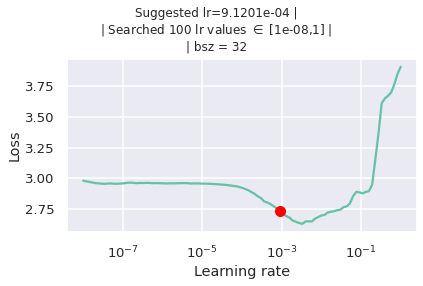

In [17]:
from lightning_hydra_classifiers.scripts.pretrain import lr_tuner


lr_tuner_results_dir = os.path.join(results_dir, f"task_{task_id}", "lr_tuner")

# logger.info(f"[Initiating Stage] lr_tuner")
lr_tune_output = lr_tuner.run_lr_tuner(trainer=trainer,
                                       model=model,
                                       datamodule=datamodule,
                                       config=config,
                                       results_dir=lr_tuner_results_dir,
                                       group=group)


# if len(lr_tune_output)==3:
#     suggestion, lr_tuner_results, config = lr_tune_output
# else:
#     suggestion, lr_tuner_results, config, lr_tuner = lr_tune_output

pp(OmegaConf.to_container(config.model, resolve=True))
print(model.hparams)

print(model.hparams_initial)

## model.fit

In [18]:
hist = trainer.fit(model, datamodule=datamodule)
print(hist)

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  rank_zero_deprecation(
2021-10-13 21:53:05,226 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     Task_1 (None): datamodule.setup(stage=fit)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


self.hparams="backbone_name": resnet50
"head_type":     linear
"hidden_size":   None
"lr":            0.0009120108393559097
"num_classes":   19
"pool_size":     1
"pool_type":     avgdrop
"pretrained":    True
"seed":          98
"weight_decay":  0.01


wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name                    | Type             | Params
-------------------------------------------------------------
0 | model                   | Sequential       | 23.5 M
1 | criterion               | CrossEntropyLoss | 0     
2 | metrics_train           | MetricCollection | 0     
3 | metrics_train_per_class | MetricCollection | 0     
4 | metrics_val             | MetricCollection | 0     
5 | metrics_val_per_class   | MetricCollection | 0     
6 | metrics_test            | MetricCollection | 0     
7 | metrics_test_per_class  | MetricCollection | 0     
-------------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.188    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 98
/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pl_bolts/callbacks/data_monitor.py:104: UserWarning: ModuleDataMonitor does not support logging with LoggerCollection. Supported loggers are: TensorBoardLogger, WandbLogger
  rank_zero_warn(


Training: 37it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(19,) (19,) (19,) (19,)
val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)
len(self.class_names)=19
val/confusion_matrix/crimson-elevator-255


Metric val_acc improved. New best score: 0.366
Epoch 0, global step 62: val_acc reached 0.36573 (best 0.36573), saving model to "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/experiment_logs/Transfer_Experiments/feature_extractor-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avgdrop/replicate_1/results/checkpoints/epoch=00-val_loss=1.230-val_acc=0.366.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(19,) (19,) (19,) (19,)
val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)
len(self.class_names)=19
val/confusion_matrix/crimson-elevator-255


Metric val_acc improved by 0.125 >= min_delta = 0.05. New best score: 0.490
Epoch 1, global step 124: val_acc reached 0.49036 (best 0.49036), saving model to "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/experiment_logs/Transfer_Experiments/feature_extractor-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avgdrop/replicate_1/results/checkpoints/epoch=01-val_loss=0.897-val_acc=0.490.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(19,) (19,) (19,) (19,)
val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)
len(self.class_names)=19
val/confusion_matrix/crimson-elevator-255


Metric val_acc improved by 0.077 >= min_delta = 0.05. New best score: 0.567
Epoch 2, global step 186: val_acc reached 0.56739 (best 0.56739), saving model to "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/experiment_logs/Transfer_Experiments/feature_extractor-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avgdrop/replicate_1/results/checkpoints/epoch=02-val_loss=0.788-val_acc=0.567.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(19,) (19,) (19,) (19,)
val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)
len(self.class_names)=19
val/confusion_matrix/crimson-elevator-255


Epoch 3, global step 248: val_acc was not in top 1


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(19,) (19,) (19,) (19,)
val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)
len(self.class_names)=19
val/confusion_matrix/crimson-elevator-255


Metric val_acc improved by 0.061 >= min_delta = 0.05. New best score: 0.629
Epoch 4, global step 310: val_acc reached 0.62877 (best 0.62877), saving model to "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/experiment_logs/Transfer_Experiments/feature_extractor-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avgdrop/replicate_1/results/checkpoints/epoch=04-val_loss=0.877-val_acc=0.629.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(19,) (19,) (19,) (19,)
val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)
len(self.class_names)=19
val/confusion_matrix/crimson-elevator-255


Epoch 5, global step 372: val_acc was not in top 1


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(19,) (19,) (19,) (19,)
val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)
len(self.class_names)=19
val/confusion_matrix/crimson-elevator-255


Epoch 6, global step 434: val_acc was not in top 1


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(19,) (19,) (19,) (19,)
val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)
len(self.class_names)=19
val/confusion_matrix/crimson-elevator-255


Epoch 7, global step 496: val_acc was not in top 1


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(19,) (19,) (19,) (19,)
val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)
len(self.class_names)=19
val/confusion_matrix/crimson-elevator-255


Epoch 8, global step 558: val_acc was not in top 1


Validating: 0it [00:00, ?it/s]

(19,) (19,) (19,) (19,)
val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)
len(self.class_names)=19
val/confusion_matrix/crimson-elevator-255


Monitored metric val_acc did not improve in the last 5 records. Best score: 0.629. Signaling Trainer to stop.
Epoch 9, global step 620: val_acc reached 0.65465 (best 0.65465), saving model to "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/experiment_logs/Transfer_Experiments/feature_extractor-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avgdrop/replicate_1/results/checkpoints/epoch=09-val_loss=0.812-val_acc=0.655.ckpt" as top 1
Saving latest checkpoint...
/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pytorch_lightning/trainer/deprecated_api.py:32: LightningDeprecationWarning: `Trainer.train_loop` has been renamed to `Trainer.fit_loop` and will be removed in v1.6.
  rank_zero_deprecation(
FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------

None


/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


<Figure size 792x720 with 0 Axes>

<Figure size 792x72 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 792x72 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 792x72 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 792x72 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 792x72 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 792x72 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 792x72 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 792x72 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 792x72 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 792x72 with 0 Axes>

## model.test

In [19]:
test_result = trainer.test()

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  rank_zero_deprecation(
2021-10-13 22:14:01,190 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     Task_1: datamodule.setup(stage=test)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  1410.2         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  112.02         	|12             	|  1344.2         	|  95.32          	|
run_training_batch                 	|  0.91536        	|720            	|  659.06         	|  46.734         	|
optimizer_step_and_closure_0       	|  0.90443        	|720            	|  651.19         	|  46.176         	|
training_step_and_backward         	|  0.3779         	|720            	|  272.09         	|  19.294         	|
on_validation_batch_end         

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.3532838225364685, 'test_loss': 2.026762008666992}
--------------------------------------------------------------------------------


## Other

In [17]:
import os
import pandas as pd 
import numpy as np
import logging
from sklearn.metrics import classification_report, f1_score

In [143]:
classification_report


# def predict_step(batch, batch_idx=None):
#     out = self.step(batch, batch_idx)
#     if hasattr(batch, "metadata"):
#         if "path" in batch.metadata:
#             out = [*out, batch.metadata["path"]]
#     return out

# self=model
# model.predict_step = predict_step
# test_results = trainer.predict(dataloaders=datamodule.test_dataloader(), return_predictions=True)
# results = collect_results(prediction_results)
prediction_results = test_results
results = collect_results(prediction_results)
len(prediction_results[0])
# len(results)

def tensors2np(t: Union[torch.Tensor, list]) -> np.ndarray:
    if isinstance(t, torch.Tensor):
        t = t.cpu().numpy()
    elif isinstance(t, list):
        t = list(map(tensors2np, t))
    if isinstance(t, np.ndarray):
        return t
    else:
        raise TypeError(f"type(t)={type(t)} is invalid for function tensors2np" + '\n' + 'tensors2np(t: Union[torch.Tensor, list]) -> np.ndarray:')
        
rows = []
for result in list(prediction_results):
    
    y_logit.append(result[0])
    y_true.append(result[1])
    y_pred.append(result[2])
    paths.extend(result[3])
    
y_logit = torch.cat(y_logit).cpu().numpy()
y_true = torch.cat(y_true).cpu().numpy()
y_pred = torch.cat(y_pred).cpu().numpy()
# paths = torch.cat(paths).cpu().numpy()

# [(r[0].device, r[0].shape, r[1].shape, r[2].shape) for r in test_results]

print(y_logit.shape, y_true.shape, y_pred.shape, len(paths))

In [ ]:
label_encoder = model.label_encoder




In [208]:
from torch.functional import F



# https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwji_bKG6cPzAhXJT98KHU0eCsg4HhAWegQIAhAB&url=https%3A%2F%2Fclear.ml%2Fdocs%2Flatest%2Fdocs%2Fguides%2Freporting%2Fexplicit_reporting%2F&usg=AOvVaw3tvUYT7fU3QHIwunDpE800
labels = model.label_encoder.classes

test_predictions_filepath = os.path.join(results_dir, f"task_{task_id}", "test_predictions.csv")


class ImageInterpretation:
    
    def __init__(self, model, datamodule, trainer, y_col: str='family'):
        self.model = model
        self.dm = datamodule
        self.trainer = trainer
        self.y_col = y_col

        
    @property
    def decoder(self):
        return self.dm.label_encoder.idx2class
        
    def decode_label(y: int): #, labels: Union[Dict[int, str], List[str]]=None):
        try:
            return self.decoder[y]
        except:
            return y
        
    def log_image_predictions(self,
                              results_path: str=None,
                              sort_by_losses: bool=True,
                              ascending: bool=True) -> pd.DataFrame:
        """
        Save table of model predictions as csv
        
        |losses	|y_true	|y_pred	|paths 	|per-class logits|
        |---	|---	|---	|---	| ---	 |---	 |
        |   	|   	|   	|   	|   	 |   	 |
        |   	|   	|   	|   	|   	 |   	 |
        
        
        """

        pred_results = trainer.predict(dataloaders=datamodule.test_dataloader(), return_predictions=True)

        results = collect_results(pred_results)

        labels = list(self.decoder.values())
        columns = ["xEnt_loss", f"{self.y_col}_true", f"{self.y_col}_pred", "paths", *[f"{l}_logit" for l in labels]]

        y_logits = torch.from_numpy(results[0].astype("float32"))
        y_true = torch.from_numpy(results[1])
        xEnt_loss = F.cross_entropy(y_logits, y_true, reduction="none")

        losses = xEnt_loss
        y_true = results[1]
        y_pred = results[2]
        paths = results[3]
        per_class_y_logits = np.hsplit(results[0], results[0].shape[1])

        num_results = len(results[0])
        rows = []
        for i in range(num_results):
            rows.append({k:v for k, v in zip(columns,
                                             [losses,
                                              self.decode_label(y=y_true[i]),
                                              self.decode_label(y=y_pred[i]),
                                              paths[i],
                                              *(y[i].item() for y in per_class_y_logits)]
                                            )
                        })

        data_df = pd.DataFrame.from_records(rows)
        
        if sort_by_losses:
            data_df = data_df.sort_values("xEnt_loss", ascending=ascending)
        
        ETL.df2csv(data_df, results_spath)
        
        return data_df

        
        

#         data = {"xEnt_loss":xEnt_loss,
#                 f"{self.y_col}_true":results[1],
#                 f"{self.y_col}_pred":results[2],
#                 "path":results[3],
#                 "y_logits":np.hsplit(results[0], results[0].shape[1])}    
    
    
    
#         rows = []
#         for i in range(num_results):
#             rows.append({k:v for k, v in zip(columns,
#                                              [data["xEnt_loss"][i], 
#                                               self.decode_label(y=data[f"{self.y_col}_true"][i]),
#                                               self.decode_label(y=data[f"{self.y_col}_pred"][i]),
#                                               data["path"][i],
#                                               *(y[i].item() for y in data["y_logits"])]
#                                             )
#                         })

#         data_df = pd.DataFrame.from_records(rows)
#         ETL.df2csv(data_df, test_predictions_filepath)



In [230]:
data_df.sort_values("Anacardiaceae_logit")

,family_true,family_pred,paths,Anacardiaceae_logit,Annonaceae_logit,Apocynaceae_logit,Betulaceae_logit,Celastraceae_logit,Combretaceae_logit,Ericaceae_logit,Fabaceae_logit,Fagaceae_logit,Lauraceae_logit,Malvaceae_logit,Melastomataceae_logit,Myrtaceae_logit,Passifloraceae_logit,Phyllanthaceae_logit,Rosaceae_logit,Rubiaceae_logit,Salicaceae_logit,Sapindaceae_logit
2382,3,3,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/train/Betulaceae/Betulaceae_Corylus_sieboldiana_Wolfe_8505.jpg,-3.701172,-1.307617,-3.009766,6.000000,-3.759766,-5.464844,-3.427734,-3.501953,2.558594,-2.662109,-0.223267,-5.761719,-5.398438,-5.808594,-5.355469,4.937500,0.086670,-2.923828,2.140625
2379,3,3,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/train/Betulaceae/Betulaceae_Carpinus_minutiserrata_Wolfe_8499.jpg,-3.636719,-0.404541,-3.140625,6.570312,-3.857422,-5.554688,-2.789062,-3.111328,2.324219,-1.705078,-0.510254,-4.355469,-4.910156,-6.250000,-5.363281,4.960938,-1.021484,-3.556641,1.875000
1310,17,17,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/train/Salicaceae/Salicaceae_Salix_paradoxa_Wolfe_18143.jpg,-3.542969,-0.666504,-0.868652,-4.914062,-1.795898,-0.714355,-3.437500,-1.461914,-1.703125,-0.938477,-1.060547,-4.484375,-1.119141,-2.339844,-0.384521,-2.453125,-0.583984,0.764648,-2.248047
2220,11,16,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/test/Melastomataceae/Melastomataceae_Miconia_candolleana_Wolfe_7579.jpg,-3.531250,-1.310547,0.375000,-3.238281,-1.906250,-0.319824,-2.828125,-0.099548,-1.003906,-1.366211,-2.339844,-2.994141,-0.514160,-2.351562,-1.755859,-1.009766,0.995605,-0.788086,-1.653320
2388,3,3,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/train/Betulaceae/Betulaceae_Betula_delavayi_Wolfe_8515.jpg,-3.523438,-1.132812,-2.919922,5.539062,-3.652344,-5.593750,-3.361328,-3.464844,2.539062,-2.875000,-0.327637,-5.246094,-4.781250,-5.527344,-5.289062,4.582031,0.183960,-2.988281,2.130859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1578,0,1,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/train/Anacardiaceae/Anacardiaceae_Anacardium_microsepalum_Wolfe_4202.jpg,2.031250,2.220703,0.378418,-1.996094,-2.458984,-5.179688,-1.397461,-1.719727,-1.301758,-0.013664,-3.351562,-2.388672,-0.104553,-4.355469,-3.957031,-1.269531,-0.753418,-3.931641,0.276123
2503,2,0,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/test/Apocynaceae/Apocynaceae_Condylocarpon_amazonicum_Wolfe_9166.jpg,2.072266,1.169922,0.980957,-1.467773,-2.337891,-5.261719,-1.712891,-1.980469,-1.117188,-1.140625,-3.160156,-1.918945,0.444092,-3.927734,-4.417969,-1.185547,-0.756348,-3.855469,0.513184
703,0,1,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/train/Anacardiaceae/Anacardiaceae_Anacardium_humile_Wolfe_12854.jpg,2.318359,2.531250,0.029694,-2.062500,-2.750000,-4.988281,-1.211914,-1.269531,-1.435547,-0.288818,-3.263672,-1.830078,-0.763672,-4.531250,-3.882812,-1.215820,-0.182251,-4.171875,-0.325928
2281,1,0,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/train/Annonaceae/Annonaceae_Cyathocalyx_pahangensis_Wolfe_7860.jpg,2.400391,1.263672,0.446533,-1.714844,-2.597656,-5.339844,-1.846680,-1.754883,-1.322266,-0.888672,-2.570312,-2.365234,-0.152954,-3.791016,-4.105469,-1.630859,-0.832520,-3.966797,0.582031


In [209]:
data_df
test_predictions_filepath

,family_true,family_pred,paths,Anacardiaceae_logit,Annonaceae_logit,Apocynaceae_logit,Betulaceae_logit,Celastraceae_logit,Combretaceae_logit,Ericaceae_logit,Fabaceae_logit,Fagaceae_logit,Lauraceae_logit,Malvaceae_logit,Melastomataceae_logit,Myrtaceae_logit,Passifloraceae_logit,Phyllanthaceae_logit,Rosaceae_logit,Rubiaceae_logit,Salicaceae_logit,Sapindaceae_logit
0,8,7,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/train/Fagaceae/Fagaceae_Lithocarpus_densiflora_Axelrod_105.jpg,-2.101562,0.946777,-2.197266,-5.257812,-1.637695,-4.351562,-0.747070,2.486328,-2.169922,1.900391,-2.886719,-4.980469,-2.761719,-3.220703,-2.039062,-2.855469,-1.358398,-2.119141,-1.598633
1,6,17,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/test/Ericaceae/Ericaceae_Arctostaphylos_bicolor_Axelrod_1064.jpg,-1.948242,-0.208008,-1.406250,-2.642578,-0.841797,-3.482422,-1.020508,-0.872070,-1.964844,-1.522461,-0.915039,-5.437500,-3.214844,-2.896484,-1.683594,0.409424,-1.733398,1.350586,-0.226807
2,7,7,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/test/Fabaceae/Fabaceae_Amorpha_californica_Axelrod_107.jpg,-1.899414,0.320557,-1.014648,-2.306641,-0.415283,-2.873047,0.164185,0.775391,-1.668945,-0.221802,-1.568359,-3.824219,-2.728516,-2.455078,-2.048828,0.622559,-1.046875,0.237793,-0.510742
3,0,7,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/test/Anacardiaceae/Anacardiaceae_Rhus_scheidana_Axelrod_1083.jpg,-2.119141,0.247192,-0.884277,-3.435547,-0.860840,-2.496094,-0.708984,0.709961,-1.564453,-0.077454,-1.122070,-3.429688,-2.224609,-2.107422,-1.483398,-0.923340,-1.385742,0.063416,-0.836426
4,15,18,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/train/Rosaceae/Rosaceae_Holodiscus_bousierii_Axelrod_11.jpg,-1.210938,-0.155151,-0.820312,-0.239014,-1.089844,-3.675781,-0.708984,-0.143677,-0.320557,-1.643555,-1.702148,-4.644531,-3.546875,-4.359375,-3.392578,1.975586,0.340088,-1.000000,2.621094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2792,7,7,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/train/Fabaceae/Fabaceae_Spatholobus_sanguineus_Wolfe_9986.jpg,-1.414062,-0.408203,-1.287109,-1.636719,-1.176758,-3.201172,-1.117188,0.658691,-0.553223,-0.359619,-0.608398,-4.261719,-3.195312,-2.927734,-2.158203,-0.062805,-0.152954,-1.143555,0.043213
2793,7,7,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/test/Fabaceae/Fabaceae_Strongylodon_lucidus_Wolfe_9991.jpg,-1.657227,-0.341553,-1.412109,-2.822266,-1.095703,-2.773438,-0.649414,1.941406,-1.231445,-0.438477,-1.717773,-4.644531,-3.406250,-3.111328,-2.568359,-0.196289,-0.147827,-1.016602,-0.682617
2794,7,7,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/test/Fabaceae/Fabaceae_Sweetia_nitens_Wolfe_9994.jpg,-1.159180,0.910645,-1.306641,-3.710938,-1.150391,-4.042969,-0.448486,0.985352,-1.852539,0.742188,-2.884766,-3.646484,-1.609375,-2.974609,-2.533203,-1.801758,-1.070312,-1.525391,-0.565918
2795,7,7,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/train/Fabaceae/Fabaceae_Templetonia_retusa_Wolfe_9995.jpg,-1.577148,-1.782227,-1.040039,-3.068359,-2.150391,-1.496094,-1.236328,3.931641,-1.172852,-2.310547,-3.220703,-5.195312,-2.341797,-3.683594,-3.480469,-0.072754,0.024765,-1.898438,-1.231445


'/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/experiment_logs/Transfer_Experiments/feature_extractor-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/task_1/test_predictions.csv'

## generate report

In [52]:
from lightning_hydra_classifiers.utils.report_utils.pandas_embed_images import df_embed_paths2imgs



df_embed_paths2imgs(df: pd.DataFrame,
                        file_path: str, 
                        path_col: str="path",
                        display: bool=False

fastprogress                   1.0.0


In [50]:
len(paths)

y_logit#.shape

2797

array([[-2.102e+00,  9.468e-01, -2.197e+00, ..., -1.358e+00, -2.119e+00,
        -1.599e+00],
       [-1.948e+00, -2.080e-01, -1.406e+00, ..., -1.733e+00,  1.351e+00,
        -2.268e-01],
       [-1.899e+00,  3.206e-01, -1.015e+00, ..., -1.047e+00,  2.378e-01,
        -5.107e-01],
       ...,
       [-1.159e+00,  9.106e-01, -1.307e+00, ..., -1.070e+00, -1.525e+00,
        -5.659e-01],
       [-1.577e+00, -1.782e+00, -1.040e+00, ...,  2.477e-02, -1.898e+00,
        -1.231e+00],
       [-9.277e-01, -4.192e-01, -9.902e-01, ..., -2.041e-03, -2.395e+00,
        -2.004e+00]], dtype=float16)

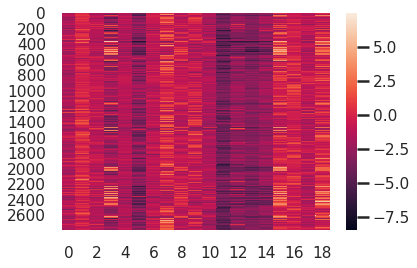

In [51]:
import seaborn as sns

sns.heatmap(y_logit)

In [ ]:
# logger = logging.getLogger(__name__)

def generate_report(y_pred,
                    y_true, 
                    labels=None,
                    results_dir: str=None):
    """Create a performance report for the current experiment and 
    consolidate the information to a general report of all runs 
    Parameters
    ----------
    opt : sklearn.model_selection.Object
        A hyperparameter 
    X_test: numpy array or pandas Dataframe 
        Input test data
    y_test: numpy array or pandas Dataframe 
        Target test data
    """


    logger.info("Generating Evaluation Report:")
    

    res = classification_report(y_true, y_pred, labels=labels, output_dict=True)
    res = pd.DataFrame(res)

    logger.info("Test report:")
    logger.info('\n \t'+ res.to_string().replace('\n', '\n\t'))
    
    f1 = f1_score(y_true, y_pred, labels=labels, average='macro')
    
    steps= [*pipeline.named_steps]

    cv_mean ,cv_std = opt.best_score_,opt.cv_results_['std_test_score'][opt.best_index_]

    tmp= pd.DataFrame({"Scaling":[steps[0]],
                        "Model":[steps[1]],
                        "params":[opt.best_params_],
                        'CV Mean':[cv_mean],
                        'CV Std':[cv_std],
                        'Test dataset':f1,
                        })

    if os.path.exists(path+"/results.csv"):
        current_csv =pd.read_csv(path+"/results.csv")
        pd.concat([current_csv, tmp], 
                   ignore_index=True
                 ).to_csv(path+"/results.csv",
                          index=False)    
    else:
        tmp.to_csv(path+"/results.csv",
                   index=False)

In [ ]:


model = LightningClassifier(backbone_name='gluon_seresnext50_32x4d',
                            pretrained=True,
                            num_classes=19,
                            pool_size=1,
                            pool_type='avgmax',
                            head_type='linear',
                            hidden_size=None,
                            lr=2e-03,
                            weight_decay=0.01,
                            seed=98)

In [20]:
# import bqplot.pyplot as plt
# from dataclasses import dataclass
# @dataclass
# class LRTunerConfig:
    
#     min_lr: float = 1e-08
#     max_lr: float = 1.0
#     num_training: int = 50
#     mode: str = 'exponential'
#     early_stop_threshold: float = 4.0

# cfg = OmegaConf.structured(LRTunerConfig())

# lr_tuner = trainer.tuner.lr_find(model,
#                                  data,
#                                  **cfg)
# lr_tuner_results = lr_tuner.results
# best_lr = lr_tuner.suggestion()

# suggestion = {"lr": best_lr,
#               "loss":lr_tuner_results['loss'][lr_tuner._optimal_idx]}

# plt.figure()
# fig = lr_tuner.plot(suggest=True)
# lr_tuner_results_dir = os.path.join(results_dir, f"task_{task_id}", "lr_tuner")

# plot_fname = 'lr_tuner_results_loss-vs-lr.png'
# plot_path = Path(lr_tuner_results_dir) / plot_fname
# plt.title(f"Suggested lr={best_lr:.4e} |\n| Searched {lr_tuner.num_training} lr values $\in$ [{lr_tuner.lr_min},{lr_tuner.lr_max}] |\n| bsz = {config.data.batch_size}", style={"fontsize":'small'})
# fig.save_png(filename=str(plot_path))

# fig = plt.figure()
# plt.plot(x=lr_tuner.results['lr'],
#          y=lr_tuner.results['loss'],
#         figure=fig)

## Display available global pool types

### Aside: Verify task_0 and task_1 label maps all agree

In [8]:
task_0_labels = data.label_encoder

data.setup(stage='fit', task_id=1)

task_1_labels = data.label_encoder

task_0_labels
task_1_labels

task_0_labels
print(f"label|task_0_idx|task_1_idx")
for label, idx in task_1_labels.class2idx.items():
    print(f"{label}|{task_0_labels.class2idx[label]}|{idx}")
    
    assert task_0_labels.class2idx[label] == idx
    
print(f"Success, all labels in task_1 have identical integer mappings to their corresponding values in task_0")

In [23]:
class2idx = data.label_encoder.class2idx
family_counts = df.value_counts("family").to_dict()

df = df.assign(class_idx=df.family.apply(lambda x: class2idx[x]),
               score = df.family.apply(lambda x: family_counts[x]))

df#.clear_intent()

df.groupby('class_idx').mean()

# df.exported.keys()

df.exported['Distribution']

df.compute_metadata()

df

df.clear_intent()

In [20]:
backbone_name='gluon_seresnext50_32x4d'
pretrained=True
num_classes=1000

head_type='linear'
hidden_size=0

pool_types = ["avg", "max", "avgmax"]

models = OrderedDict({})

for pool_type in pool_types:
    models[pool_type] = build_model(backbone_name=backbone_name,
                                    pretrained=pretrained,
                                    num_classes=num_classes,
                                    pool_size=1,
                                    pool_type=pool_type,
                                    head_type=head_type,
                                    hidden_size=hidden_size)
print(f"backbone={backbone_name}|pretrained={pretrained}|num_classes={num_classes}|head_type={head_type}|hidden_size={hidden_size}")
for pool_type, model in models.items():
    print(f"pool_type={pool_type}")
    pp({k: v.shape for k,v in model.head.named_parameters()})
#     pp(list(dict(model.head.named_parameters()).keys()))

dict_keys(['backbone_name', 'pretrained', 'num_classes', 'pool_size', 'pool_type', 'head_type', 'hidden_size', 'backbone', 'feature_size'])
dict_keys(['backbone_name', 'pretrained', 'num_classes', 'pool_size', 'pool_type', 'head_type', 'hidden_size', 'backbone', 'feature_size'])
dict_keys(['backbone_name', 'pretrained', 'num_classes', 'pool_size', 'pool_type', 'head_type', 'hidden_size', 'backbone', 'feature_size'])
backbone=gluon_seresnext50_32x4d|pretrained=True|num_classes=1000|head_type=linear|hidden_size=0
pool_type=avg


{'classifier.weight': torch.Size([1000, 4096]), 'classifier.bias': torch.Size([1000])}

pool_type=max


{'classifier.weight': torch.Size([1000, 4096]), 'classifier.bias': torch.Size([1000])}

pool_type=avgmax


{'classifier.weight': torch.Size([1000, 8192]), 'classifier.bias': torch.Size([1000])}

## Display available head types (TBD)

In [20]:
backbone_name='gluon_seresnext50_32x4d'
pretrained=True
num_classes=1000

head_types=['linear', 'custom']
hidden_size=0

pool_types = ["avg", "max", "avgmax"]

models = OrderedDict({})

for pool_type in pool_types:
    models[pool_type] = build_model(backbone_name=backbone_name,
                                    pretrained=pretrained,
                                    num_classes=num_classes,
                                    pool_size=1,
                                    pool_type=pool_type,
                                    head_type=head_type,
                                    hidden_size=hidden_size)
print(f"backbone={backbone_name}|pretrained={pretrained}|num_classes={num_classes}|head_type={head_type}|hidden_size={hidden_size}")
for pool_type, model in models.items():
    print(f"pool_type={pool_type}")
    pp({k: v.shape for k,v in model.head.named_parameters()})
#     pp(list(dict(model.head.named_parameters()).keys()))

dict_keys(['backbone_name', 'pretrained', 'num_classes', 'pool_size', 'pool_type', 'head_type', 'hidden_size', 'backbone', 'feature_size'])
dict_keys(['backbone_name', 'pretrained', 'num_classes', 'pool_size', 'pool_type', 'head_type', 'hidden_size', 'backbone', 'feature_size'])
dict_keys(['backbone_name', 'pretrained', 'num_classes', 'pool_size', 'pool_type', 'head_type', 'hidden_size', 'backbone', 'feature_size'])
backbone=gluon_seresnext50_32x4d|pretrained=True|num_classes=1000|head_type=linear|hidden_size=0
pool_type=avg


{'classifier.weight': torch.Size([1000, 4096]), 'classifier.bias': torch.Size([1000])}

pool_type=max


{'classifier.weight': torch.Size([1000, 4096]), 'classifier.bias': torch.Size([1000])}

pool_type=avgmax


{'classifier.weight': torch.Size([1000, 8192]), 'classifier.bias': torch.Size([1000])}

## Creating fit method

In [13]:
#Borrowed from fastai2 library

bn_types = (torch.nn.modules.batchnorm.BatchNorm1d,torch.nn.modules.batchnorm.BatchNorm2d,torch.nn.modules.batchnorm.BatchNorm3d)
 
def set_bn_eval(m:nn.Module)->None:
    "Set bn layers in eval mode for all recursive children of `m`."
    for l in m.children():
        if isinstance(l, bn_types) and not next(l.parameters()).requires_grad:
            l.eval()
        set_bn_eval(l)

In [14]:
def fit(epochs,model,train_dl,valid_dl,loss_fn,opt,device=None,bn_eval=False):
    if device is None:
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    mb = master_bar(range(epochs))
    mb.write(['epoch','train_loss','valid_loss','trn_acc','val_acc'],table=True)
    model.to(device)

    for i in mb:    
        trn_loss,val_loss = 0.0,0.0
        trn_acc,val_acc = 0,0
        trn_n,val_n = len(train_dl.dataset),len(valid_dl.dataset)
        model.train()
        if bn_eval:set_bn_eval(model)
        for xb,yb in progress_bar(train_dl,parent=mb):
            xb,yb = xb.to(device), yb.to(device)
            out = model(xb)
            opt.zero_grad()
            loss = loss_fn(out,yb)
            _,pred = torch.max(out.data, 1)
            trn_acc += (pred == yb).sum().item()
            trn_loss += loss.item()
            loss.backward()
            opt.step()
        trn_loss /= mb.child.total
        trn_acc /= trn_n

        model.eval()
        with torch.no_grad():
            for xb,yb in progress_bar(valid_dl,parent=mb):
                xb,yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = loss_fn(out,yb)
                val_loss += loss.item()
                _,pred = torch.max(out.data, 1)
                val_acc += (pred == yb).sum().item()
        val_loss /= mb.child.total
        val_acc /= val_n

        mb.write([i,f'{trn_loss:.6f}',f'{val_loss:.6f}',f'{trn_acc:.6f}',f'{val_acc:.6f}'],table=True)        
        
    

## Training

In [6]:
loss_fn = F.cross_entropy

In [9]:
def freeze(model,bn_freeze=True):
    for name,param in model.named_parameters():
        if bn_freeze:
            param.requires_grad = False
        elif name.find('bn') == -1:
            param.requires_grad = False
            
def unfreeze(model):
    for param in model.parameters():
        param.requires_grad = True

def get_model(lrs=[1e-3,1e-3],bn_freeze=True):
    model = MyResNet()
    freeze(model.body,bn_freeze=bn_freeze)
    opt = optim.Adam([{'params': model.body.parameters(), 'lr':lrs[0]},
                {'params': model.head.parameters(), 'lr': lrs[1]}])
    return model,opt

def update_lr(lr,opt):
    opt.param_groups[0]['lr'] = lr/100
    opt.param_groups[1]['lr'] = lr
    

### Freeze the complete resnet body

lr = 1e-3
model,opt = get_model(lrs=[lr,lr],bn_freeze=True)
fit(2,model,trn_dl,valid_dl,loss_fn,opt)

### Freeze the complete resnet body and place BN layers in eval mode.

lr = 1e-3
model,opt = get_model(lrs=[lr,lr],bn_freeze=True)
fit(2,model,trn_dl,valid_dl,loss_fn,opt,bn_eval=True)

### Freeze the complete resnet body and place BN layers in eval mode and train the body at a lesser learning rate for the second epoch.

In [17]:
lr = 1e-3
model,opt = get_model(lrs=[lr,lr],bn_freeze=True)
fit(1,model,trn_dl,valid_dl,loss_fn,opt,bn_eval=True)

epoch,train_loss,valid_loss,trn_acc,val_acc
0,0.115747,0.044909,0.964774,0.987107


In [18]:
update_lr(lr/2,opt)
unfreeze(model)
fit(1,model,trn_dl,valid_dl,loss_fn,opt)

epoch,train_loss,valid_loss,trn_acc,val_acc
0,0.074065,0.024733,0.973581,0.991509


### Freeze the resnet body except fot BN layers

In [28]:
model,opt = get_model(lrs=[1e-3,1e-3],bn_freeze=False)
fit(2,model,trn_dl,valid_dl,loss_fn,opt)

epoch,train_loss,valid_loss,trn_acc,val_acc
0,0.105815,0.032677,0.960843,0.988365
1,0.052449,0.022727,0.982151,0.990881


### Freeze the resnet body except fot BN layers and try smaller leraning rate for the resnet body

In [12]:
model,opt = get_model(lrs=[lr,lr],bn_freeze=False)
fit(1,model,trn_dl,valid_dl,loss_fn,opt)
update_lr(lr/2,opt)
unfreeze(model)
fit(1,model,trn_dl,valid_dl,loss_fn,opt)

epoch,train_loss,valid_loss,trn_acc,val_acc
0,0.145204,0.052064,0.951329,0.983648


epoch,train_loss,valid_loss,trn_acc,val_acc
0,0.064199,0.020451,0.977669,0.993711


### Try adjusting the model

In [20]:
class AdaptiveConcatPooling(nn.Module):
    def forward(self,x):
        avg_pool = F.adaptive_avg_pool2d(x,1)
        max_pool = F.adaptive_max_pool2d(x,1)
        return torch.cat([avg_pool,max_pool],dim=1)

In [21]:
class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet34(pretrained=True)
        self.body = nn.Sequential(*list(resnet.children())[:-2])
        self.head = nn.Sequential(AdaptiveConcatPooling(),Flatten(),nn.Linear(512*2,2))
    
    def forward(self,x):
        x = self.body(x)
        return self.head(x)

In [23]:
lr = 1e-3
model,opt = get_model(lrs=[lr,lr],bn_freeze=False)
fit(1,model,trn_dl,valid_dl,loss_fn,opt)
update_lr(lr/2,opt)
unfreeze(model)
fit(1,model,trn_dl,valid_dl,loss_fn,opt)

epoch,train_loss,valid_loss,trn_acc,val_acc
0,0.124573,0.033491,0.952115,0.987421


epoch,train_loss,valid_loss,trn_acc,val_acc
0,0.057533,0.032403,0.980893,0.990252


### Increasing the complexity of the model

In [24]:
class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        nf = 512*2
        resnet = models.resnet34(pretrained=True)
        self.body = nn.Sequential(*list(resnet.children())[:-2])
        self.head = nn.Sequential(AdaptiveConcatPooling(),Flatten(),nn.BatchNorm1d(nf),nn.Dropout(p=0.25),
                      nn.Linear(nf,nf//2,bias=False),nn.ReLU(inplace=True),nn.BatchNorm1d(nf//2),nn.Dropout(p=0.75),
                      nn.Linear(nf//2,2,bias=False))
    
    def forward(self,x):
        x = self.body(x)
        return self.head(x)

In [25]:
lr = 1e-3
model,opt = get_model(lrs=[lr,lr],bn_freeze=False)
fit(1,model,trn_dl,valid_dl,loss_fn,opt)
update_lr(lr/2,opt)
unfreeze(model)
fit(1,model,trn_dl,valid_dl,loss_fn,opt)

epoch,train_loss,valid_loss,trn_acc,val_acc
0,0.097272,0.027744,0.966032,0.989308


epoch,train_loss,valid_loss,trn_acc,val_acc
0,0.056163,0.023533,0.979557,0.992767


## scratch

In [ ]:


                

# ## WIP: display_layer_status
#     @classmethod
#     def display_layer_status(cls,
#                              model: nn.Module,
#                              max_depth: int=3):
#         """
#         Return a formatted display of model's layers alongside relevant training status info.
#         """
#         modules = []
        
# #         for name, module in model.named_modules():
#         for name, module in model.named_children():
# #             print(name, 'max_depth:', max_depth)
#             if name=="": continue
# #             if (max_depth>0) and (len(list(module.named_modules())) > 0):
#             if (max_depth>0) and (len(list(module.named_children())) > 0):
#                 modules.extend(cls.display_layer_status(module, max_depth=max_depth-1))
#                 continue
#             module_out = {"name":name,
#                           "training":module.training,
#                           "type":type(module),
#                           "params":[]}
#             for param_name, param in module.named_parameters():
#                 module_out["params"].append({
#                     "name":param_name,
#                     "type":type(param),
#                     "requires_grad":param.requires_grad,
#                     "shape":param.shape
#                 })
#             print(name)
#             pp(module_out)
#             modules.append(module_out)
#         return modules


In [388]:
# for unfreeze_down_to in reversed(range(0,-8,-1)):
# model.freeze_backbone(freeze_bn=False)
# model.freeze_backbone(freeze_bn=True)
# summary(model.model)
# count_trainable_batchnorm_layers(model)

# for unfreeze_down_to in range(0,-9,-1):
#     print(unfreeze_down_to)
#     print(f"Unfreezing backbone down to layer: {unfreeze_down_to}")
#     model.unfreeze_backbone_top_layers(unfreeze_down_to=unfreeze_down_to)
# #     summary(model.model)
#     model.count_trainable_batchnorm_layers()
# #     count_trainable_batchnorm_layers(model)

#     print(f"trainable parameters: {len(list(model.get_trainable_parameters()))}")
#     print(f"non-trainable parameters: {len(list(model.get_nontrainable_parameters()))}")

# unfreeze_down_to = -2

# model.unfreeze_backbone_top_layers(unfreeze_down_to=unfreeze_down_to)
# summary(model.model)
# count_trainable_batchnorm_layers(model)

# print(f"trainable parameters: {len(list(model.get_trainable_parameters()))}")
# print(f"non-trainable parameters: {len(list(model.get_nontrainable_parameters()))}")

# unfreeze_down_to = -3

# model.unfreeze_backbone_top_layers(unfreeze_down_to=unfreeze_down_to)
# summary(model.model)
# print(f"trainable: {len(list(model.get_trainable_parameters()))}")
# print(f"non-trainable: {len(list(model.get_nontrainable_parameters()))}")

# unfreeze_down_to = -4

# model.unfreeze_backbone_top_layers(unfreeze_down_to=unfreeze_down_to)
# summary(model.model)
# print(f"trainable: {len(list(model.get_trainable_parameters()))}")
# print(f"non-trainable: {len(list(model.get_nontrainable_parameters()))}")

In [ ]:


#     model = timm.create_model(model_name=backbone_name, num_classes=1000, pretrained=pretrained)
#     if isinstance(pretrained, str) and pretrained != "imagenet":
#         model = load_model_checkpoint(model, ckpt_path=pretrained)
# #         ckpt_pth = glob.glob(hydra.utils.to_absolute_path(pretrained))
# #         model = model.load_state_dict(torch.load(ckpt_pth[0]))
        
#     body = nn.Sequential(*list(model.children())[:-2])

    
#     feature_size = model.fc.in_features
    
#     head = OrderedDict()
#     global_pool, feature_size = build_global_pool(pool_type=pool_type,
#                                                   pool_size=pool_size,
#                                                   feature_size=feature_size)
#     head["global_pool"] = global_pool
#     head["flatten"] = Flatten()
    
#     classifier_input_feature_size = feature_size*(pool_size*2)        
#     if head_type=='linear':
#         head["classifier"] = nn.Linear(classifier_input_feature_size, num_classes)
#     elif head_type=='custom':
#         head["classifier"] = nn.Sequential(nn.Linear(classifier_input_feature_size, hidden_size),
#                                 nn.RReLU(lower=0.125, upper=0.3333333333333333, inplace=False),
#                                 nn.BatchNorm1d(hidden_size),
#                                 nn.Linear(hidden_size, num_classes))
        
#     head = nn.Sequential(head)


#     model = nn.Sequential(OrderedDict({
#         "body":body,
#         "head":head
#     }))
#     return model

# def build_model(backbone_name='gluon_seresnext50_32x4d',
#                 pretrained: Union[bool, str]=True,
#                 num_classes: int=1000,
#                 pool_size: int=1,
#                 pool_type: str='avg',
#                 head_type: str='linear',
#                 hidden_size: Optional[int]=512):
    
#     try:
#         model = build_timm_custom(backbone_name=backbone_name,
#                                   pretrained=pretrained,
#                                   num_classes=num_classes,
#                                   pool_size=pool_size,
#                                   pool_type=pool_type,
#                                   head_type=hidden_size,
#                                   hidden_size=hidden_size)

#     except:
#         print

        
        
        